 

---
### 1. Import the libraries that we need

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy

from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Data preparation

In [2]:
train_path  = 'data/train'
valid_path  = 'data/valid'
test_path  = 'data/test'

In [3]:
# ImageDataGenerator generates batches of tensor image data with real-time data augmentation. 
# The data will be looped over (in batches).
# in this example, we won't be doing any image augmentation
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=(224,224), 
                                                         batch_size=10)

valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
                                                         target_size=(224,224), 
                                                         batch_size=30)

test_batches = ImageDataGenerator().flow_from_directory(test_path, 
                                                        target_size=(224,224), 
                                                        batch_size=50, 
                                                        shuffle=False)

Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


### 3. VGG16 base model pre-trained on ImageNet dataset

In [22]:
base_model = vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3), pooling='avg')

### 2. freeze the classification layers in the base model

In [5]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in base_model.layers[:-5]:
    layer.trainable = False


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
# save the output of the base_model to be the input of the next layer
last_output = base_model.output
 
# add our new softmax layer with 10 hidden units
x = Dense(2, activation='softmax', name='softmax')(last_output)
 
# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_model.input, outputs=x)
 

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

### 4. Train the new model

In [8]:
new_model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='signlanguage.model.hdf5', save_best_only=True)

history = new_model.fit_generator(train_batches, steps_per_epoch=18,
                   validation_data=valid_batches, validation_steps=3, epochs=20, verbose=1, callbacks=[checkpointer])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
18/18 [==============================] - 41s 2s/step - loss: 0.8865 - accuracy: 0.6333 - val_loss: 0.4158 - val_accuracy: 0.8000
Epoch 2/20
18/18 [==============================] - 42s 2s/step - loss: 0.4067 - accuracy: 0.8056 - val_loss: 0.3910 - val_accuracy: 0.8444
Epoch 3/20
18/18 [==============================] - 45s 2s/step - loss: 0.4743 - accuracy: 0.7500 - val_loss: 0.3781 - val_accuracy: 0.8333
Epoch 4/20
18/18 [==============================] - 43s 2s/step - loss: 0.3909 - accuracy: 0.8056 - val_loss: 0.3840 - val_accuracy: 0.8333
Epoch 5/20
18/18 [==============================] - 45s 3s/step - loss: 0.4201 - accuracy: 0.7833 - val_loss: 0.4183 - val_accuracy: 0.8333
Epoch 6/20
18/18 [==============================] - 48s 3s/step - loss: 0.3999 - accuracy: 0.7944 - val_loss: 0.5130 - val_accuracy: 0.7778
Epoch 7/20
18/18 [==============================] - 43s 2s/step - loss: 0.3698 - acc

### 5. create the confusion matrix to evaluate the model

In [16]:
def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return paths, targets

In [17]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

test_files, test_targets = load_dataset('data/test')

In [18]:
from keras.preprocessing import image  
from keras.applications.vgg16 import preprocess_input
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensor(test_files))




  0%|                                                  | 0/200 [00:00<?, ?it/s]


100%|██████████████████████████████████████| 200/200 [00:00<00:00, 1086.78it/s]


In [19]:
new_model.load_weights('signlanguage.model.hdf5')

In [20]:
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*new_model.evaluate(test_tensors, test_targets)))

 69%|███████████████████████████▍            | 138/201 [03:49<01:44,  1.66s/it]


 49%|███████████████████▌                    | 98/201 [00:17<00:00, 970.26it/s]

7/7 [==============================] - 21s 3s/step - loss: 0.5632 - accuracy: 0.7500

Testing loss: 0.5632
Testing accuracy: 0.7500


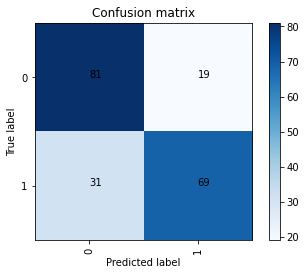

In [21]:
from sklearn.metrics import confusion_matrix

cm_labels = ['0','1']

cm = confusion_matrix(np.argmax(test_targets, axis=1),
                      np.argmax(new_model.predict(test_tensors), axis=1))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
indexes = np.arange(len(cm_labels))
for i in indexes:
    for j in indexes:
        plt.text(j, i, cm[i, j])
plt.xticks(indexes, cm_labels, rotation=90)
plt.xlabel('Predicted label')
plt.yticks(indexes, cm_labels)
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [23]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in base_model.layers[:-4]:
    layer.trainable = False